# In this assignment, you will implement the PCA and the k-means algorithm
### 100 points total

In [1]:
# clear all variables
%reset_selective -f a
#import 
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
import time

## Load data from data.csv file (5 Points)


In [2]:
# Complete the function below to load the data from data.csv. 
# Return X where X is a 1000 by 500 (m=1000 and d=500. d is the number of features)

import pandas as pd

def load_data(file_name):
    # write your code here
    data = pd.read_csv(file_name, header=None)
    X = data.values
   
    return X

In [3]:
X = load_data("data.csv")
# Here confirming the dimensions: 1000 x 500
X.shape

(1000, 500)

# Before clustering the data, implement PCA to reduce the dimensionality from 500 to 2.

## Preprocess the data (5 Points)

In [4]:
# perform any preprocessing steps in the function below.
from sklearn.preprocessing import StandardScaler
def pre_process(X):
    # write your code here
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

## Implement PCA to reduce the dimensionality to 2 (30 points if from scratch, 10 points if using a PCA function from a library)

In [5]:
# the below function takes X as (m by 500) and return it as (m by 2) after performing PCA. 
# If implementing from scratch, you can use functions from numpy and numpy.linalg etc

def my_PCA(X):
    # write your code here
    # Per the lecture, pass n=500 data points and calculate the mean vector (mu) of the data set
    mean_vector = np.mean(X, axis=0)

    # Per the lecture, calculate the covariance matrix utilizing the covariance matrix formula

    # xi - mean
    X_distance = X - mean_vector

    # S = 1/n Σ(xi - mean)(xi - mean)^T
    n = X.shape[0]
    S = (1/n) * np.dot(X_distance.T, X_distance)

    # Per the lecture, calculate the eigenvalues and eigenvectors; here utilizing np.linalg
    eigenvalues, eigenvectors = np.linalg.eig(S)

    # Per the lecture, select top r eigenvectors
    # necessary to sort the eigenvalues first in descending order
    descending_eigenvalues = np.argsort(eigenvalues)[::-1]
    # In this case, r=2
    r = 2
    # construct the W columns of top r eigenvectors
    W = eigenvectors[:, descending_eigenvalues[:r]]

    # Per the lecture, project the samples onto the eigenvectors using the formula
    # yi = W^T(xi - mean)
    X_2d = np.dot(X_distance, W) # note that I am not using the transpose of W here (rows); instead I am using the W columns of eigenvectors
    
    return X_2d    

(1000, 2)


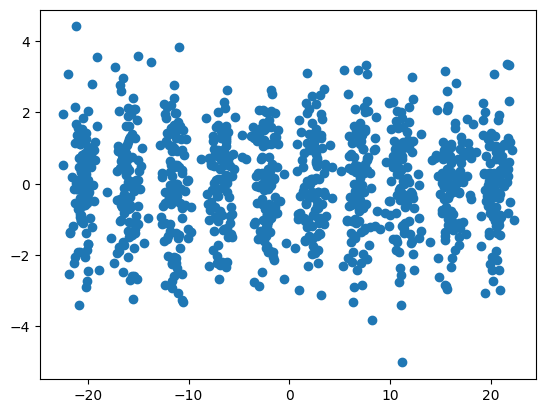

In [6]:
X = pre_process(X)
X_2d = my_PCA(X)
# check out the shape and scatter plot the points
print(X_2d.shape)
plt.scatter(X_2d[:,0],X_2d[:,1])

# K-means

## Start by implementing a function that randomly initialises centroids (5 points).

In [7]:
#input:
#k: number of centers
#X: the data
# return
# centroids is a k by 2 
def initialise_centroids(X,k):    
    
    minimum = np.min(X, axis=0)
    maximum = np.max(X, axis=0)
    size = (k, X.shape[1])

    centroids = np.random.uniform(minimum, maximum, size)
    
    return centroids

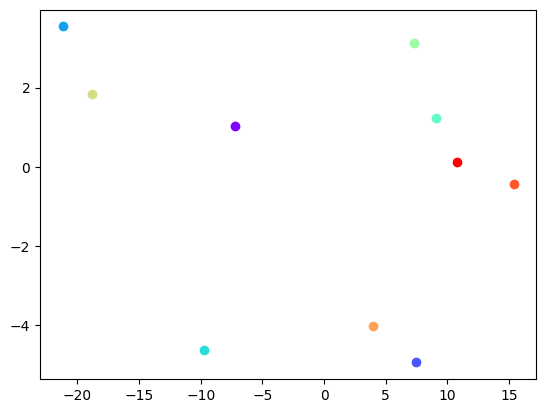

In [8]:
centroids = initialise_centroids(X_2d,10)

# the code below will plot the centroids
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(centroids))))
for c in centroids:
    plt.scatter(c[0], c[1], color=next(colors))

## Implement a function that takes the matrix X and a set of centroids and assigns each point in X to a cluster (5 points)

In [9]:
from scipy.spatial.distance import cdist
#input
# X is a m by 2 point 
# centroids is a k by 2 , the center of k clusters.
#return cluster_assignments is an m by 1 vector. the id of the cluster for each point in X
def assign(X,centroids):

    distance_matrix = cdist(X, centroids)
    cluster_assignments = np.argmin(distance_matrix, axis=1)
    
    return cluster_assignments

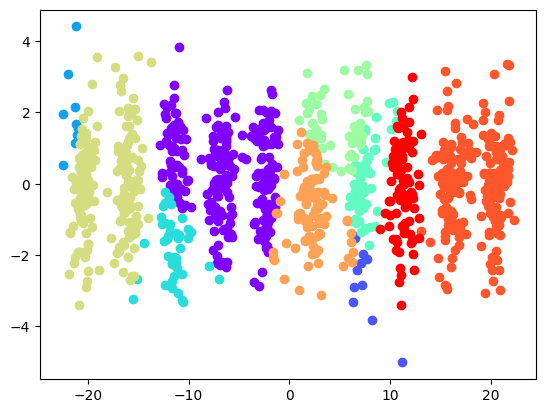

In [10]:
cluster_assignments = assign(X_2d,centroids)

# the code below will plot the points color-coded according to their cluster
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(centroids))))
for k in np.unique(cluster_assignments):
    plt.scatter(X_2d[cluster_assignments==k,0], X_2d[cluster_assignments==k,1], color=next(colors))

## Next, implement a function to compute the value of a cost function given a set of centroids and assignments (10 points)

In [11]:
def cost(X,cluster_assignments,centroids):

    '''Per the lecture, here utilizing the k-means objective function: "There are many possible ways to define this concept, 
    but by far the most common choice involves squared Euclidean distance. 
    In other words, the within-cluster variation for the kth cluster 
    is the sum of all of the pairwise squared Euclidean distances between the observations in the kth cluster, 
    divided by the total number of observations in the kth cluster."

    Variable names follow convention in the lecture. I have tried to match the formula as closely as possible with the code structure.
    I have included a markdown version of the formula below for reference.'''

    K = centroids.shape[0] # where K is the clusters
    cost = 0 # initializing the outer cost summation

    for k in range(K): 
        Ck = X[cluster_assignments == k] # where Ck is the kth cluster
        W = 0 # where W is W(Ck) or the within-cluster variation of the kth cluster; initializing the within-cluster inner summation
        for xi in range(len(Ck)): 
            for xj in range(len(Ck)):
                W += np.sum((Ck[xi] - Ck[xj])**2) # the innermost summation of the squared Euclidean distances
        if len(Ck) > 0: # Including this edge case to avoid zero division in case of an empty cluster
            W = W / len(Ck) 
        cost += W # the outermost summation of the within-cluster variations across all clusters
    return cost

### K-Means Objective Function:
$$minimize(C_1,..., C_K) = \sum_{k=1}^{K} \left[ \frac{1}{|C_k|} \cdot \sum_{i, i' \in C_k} \sum_{j=1}^{l} (x_{ij} - x_{i'j})^2 \right]$$

In [12]:
# the code below tests your functions
k=10
centroids = initialise_centroids(X_2d,k)
cluster_assignments = assign(X_2d,centroids)
c = cost(X_2d,cluster_assignments,centroids)
print(c)

13100.88126611119


## Implement a function to perform the k-means algorithm using the functions you implemented above (40 points, 10 if you use a kmean function from a library)

In [13]:
def My_Kmeans(X, k, num_of_iterations, epochs=5):

    '''Per the lecture:
    1. Randomly assign a number, from 1 to K, to each of the observations. 
    These serve as initial cluster assignments for the observations.
    (a) For each of the K clusters, compute the cluster centroid. The kth cluster centroid is the vector 
    of the p feature means for the observations in the kth cluster.
    (b) Assign each observation to the cluster whose centroid is closest
    (where closest is defined using Euclidean distance)
    2. Iterate until the cluster assignments stop changing:
    in this case, based on the number of iterations

    Note: In first developing the algorithm in a less complex manner,
    I was not satisfied with the variance between the algorithm's output and the expected or True output because of the randomly initiated centroids.
    I have thus modified the algorithm, at the expense of time complexity, to iterate over epochs with several options for centroids
    in order to find the lowest cost and thus a better fit.
    
    Default epochs set to 5'''
    
    lowest_cost = np.inf # Here taking inspiration from Dijkstra's algorithm with initilization of infinity
    optimal_centroids = None
    optimal_cluster_assignments = None
    epoch_costs = [] # I have amended the return to include a list of all costs per epoch for plotting

    for _ in range(epochs):

        centroids = initialise_centroids(X, k)
        costs = [] 

        for _ in range(num_of_iterations):

            cluster_assignments = assign(X, centroids)
            
            # Including this edge case to avoid zero division (due to an empty cluster)
            for n in range(k):
                if np.sum(cluster_assignments == n) == 0:
                    centroids[n] = X[np.random.randint(X.shape[0])]

            for n in range(k):
                observations = []
                for xk in range(X.shape[0]):
                    if cluster_assignments[xk] == n:
                        observations.append(X[xk])
                centroids[n] = np.mean(observations, axis=0)
            
            costs.append(cost(X, cluster_assignments, centroids))

        epoch_costs.append(costs[-1])
        
        if costs[-1] < lowest_cost:
            lowest_cost = costs[-1]
            optimal_centroids = centroids
            optimal_cluster_assignments = cluster_assignments
    
    return optimal_cluster_assignments, optimal_centroids, epoch_costs, lowest_cost


In [ ]:
k = 10
centroids = []
optimal_cluster_assignments, optimal_centroids, epoch_costs, lowest_cost = My_Kmeans(X_2d,k,1000)

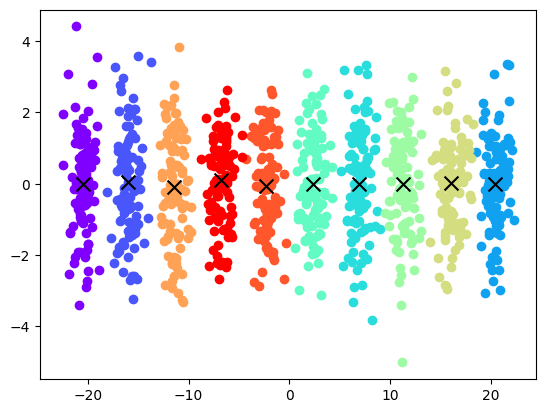

In [20]:
# the code below will plot the points color-coded according to their cluster

k_clusters = 10
colors = plt.cm.rainbow(np.linspace(0, 1, k_clusters))

for k in range(k_clusters):
    plt.scatter(X_2d[optimal_cluster_assignments==k,0], X_2d[optimal_cluster_assignments==k,1], color=colors[k])

for k in range(k_clusters):
    plt.scatter(optimal_centroids[k][0], optimal_centroids[k][1], marker="x", s=100, c='k')

plt.show()


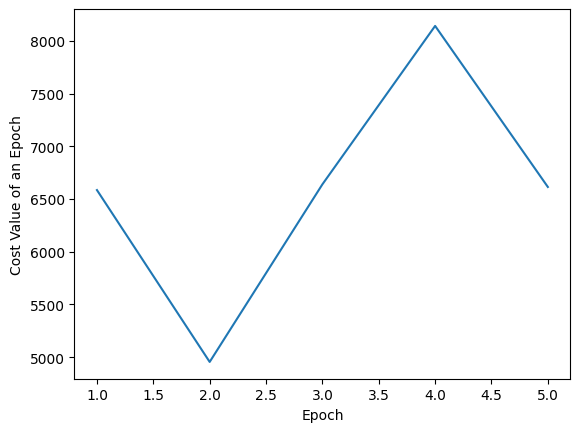

lowest cost: 4954.468588357131


In [21]:
# Here plotting the cost function over each epoch as mentioned previously

plt.plot(range(1, len(epoch_costs) + 1), epoch_costs)
plt.xlabel('Epoch')
plt.ylabel('Cost Value of an Epoch')
plt.show()

print(f"lowest cost: {lowest_cost}")

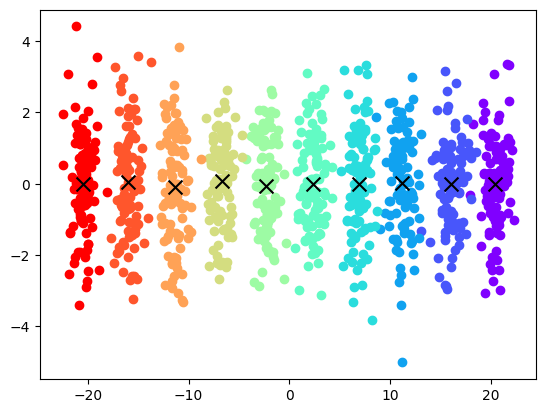

In [16]:
k = 10
cluster_assignments = load_data("True_clusters_IDs.csv")
centroids = []
for idx in range(k):            
    temp_cent = X_2d[cluster_assignments.flatten()==idx].mean(axis=0)             
    centroids.append(temp_cent)
            
# the code below will plot the points color-coded according to their cluster
colors = iter(plt.cm.rainbow(np.linspace(0, 1, k)))
for k in range(k):
    plt.scatter(X_2d[cluster_assignments.flatten()==k,0], X_2d[cluster_assignments.flatten()==k,1], color=next(colors))
    plt.scatter(centroids[k][0],centroids[k][1],marker="x",s=100,c='k')